In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
from scipy.special import expit

In [22]:
class Layer:

    #Activation Functions
    def tanh(self, x):
        return np.tanh(x)
    def d_tanh(self, x):
        return 1 - np.square(np.tanh(x))
    def sigmoid(self, x):
#         return 1/(1+ np.exp(-x))
        return expit(x)
    def d_sigmoid(self, x):
        return (1 - self.sigmoid(x)) * self.sigmoid(x)
    def ReLu(self, z):
        return np.maximum(0, z)
    def d_ReLu(self, Z):
        return Z > 0
    
    #For output layer, useful for multiclass classification
    def softmax(self, Z):
#         expZ = np.exp(Z - np.max(Z))
#         return expZ / expZ.sum(axis=0, keepdims=True)
         return np.exp(Z) / sum(np.exp(Z))
    def d_softmax(self, Z):
        pass
    
    activationFunctions = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'reLu': (ReLu, d_ReLu),
        'softmax': (softmax, d_softmax)
    }
    
    #Input -> num of neurons in prev layer, Neurons --> num neurons in cur layer, Activation -> activation fxn to use
    def __init__(self, inputs, neurons, activation):
        self.neurons = neurons
        self.W = np.random.rand(neurons, inputs) - 0.5
        self.b = np.random.rand(neurons, 1) - 0.5
        self.Z = None
        self.A_prev = None
        self.act, self.d_act = self.activationFunctions.get(activation)
        
    def initializeWeights(self, inputs, neurons):
        self.W = np.random.randn(neurons, inputs)
        
    def getNeuronCount(self):
        return self.neurons
    
    def feedForward(self, A_prev):
        ipdb.set_trace()
        self.A_prev = A_prev
        self.Z = self.W.dot(self.A_prev) + self.b
        self.A = self.act(self, self.Z)
        return self.A
    
    #All derivatives are wrt to cost
    #Expects dA of cur layer
    #Special case where doing multi class classification with mutli class logloss, you can get the dZ wrt dC directly without having to first get dA
    def backprop(self, dA, learning_rate, dZ_Special):
        
        ipdb.set_trace()
        
        #elementt by element matrix multip, not a normal dot prod since both matrices have same shape (essentialyl scalar)
        dZ = np.multiply(self.d_act(self, self.Z), dA) if dZ_Special.any() == None else dZ_Special
        
         # need to normalize weights and divide by number of samples
        # because it is actually a sum of weights
        dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
        
        # this is to match shape since biases is supposed to be a col vector with 1 col but dZ has m cols
        # w/ m being num of samples, we want to take avg of all samples in dZ (i.e on a row by row basis, sum of cols
        # and divide by total num of smamples)
        db = 1 / dZ.shape[1] * np.sum(dZ, axis = 1, keepdims = True)
        
        dA_prev = np.dot(self.W.T, dZ)
        
        self.W = self.W - learning_rate * dW
        self.b = self.b - learning_rate * db
        return dA_prev
    

In [23]:
class NeuralNet:
    
    #Loss Functions, mse for regression, logloss for classification
    def mse(self, a, target):
        return np.square(a-target)
    
    def d_mse(self, a, target):
        return 2*(a-target)
    
    def binary_logloss(self, a, target):
        return -(target*np.log(a) + (1-target)*np.log(1-a))
    
    def d_binary_logloss(self, a, target):
        return (a - target)/(a*(1 - a))
    
    def multi_logloss(self, a, target, eps=1e-15):
        predictions = np.clip(a, eps, 1 - eps)

        # normalize row sums to 1
        predictions /= predictions.sum(axis=1)[:, np.newaxis]

        return -np.sum(target * np.log(predictions))/predictions.shape[0]
    
    def d_multi_logloss(self, a, target):
        return np.zeros(a.shape) # kinda just a placeholder
    
    lossFunctions = {
        'mse': (mse, d_mse),
        'binary_logloss': (binary_logloss, d_binary_logloss),
        'multi_logloss': (multi_logloss, d_multi_logloss)
    }
        
    #LossFunction is either mse of logloss
    def __init__(self, lossFunction):
        self.layers = []
        self.learning_rate = 0.1
        self.epochs = 100
        self.batch_size = 10
        self.classification = False if lossFunction == 'mse' else True
        self.lossFunction = lossFunction
        self.loss, self.d_loss = self.lossFunctions.get(lossFunction)
    
    #Units is 1-n and activationFunction is 'ReLu', 'sigmoid', 'tanh', or 'softmax'
    def addLayer(self, units, activationFunction):
        prevLayerNeuronCount = self.layers[-1].getNeuronCount() if len(self.layers) > 0 else 0
        self.layers.append(Layer(prevLayerNeuronCount, units, activationFunction))
        
    def getNumBatches(self, num_samples, batch_size):
        if (num_samples == batch_size):
            return 1
        elif (num_samples > batch_size):
            if (num_samples % batch_size == 0):
                return num_samples // batch_size
            else:
                return (num_samples // batch_size) + 1
        else:
            return 1
        
    def oneHot(self, x):
        one_hot_X = np.zeros((x.max() + 1, x.size)) #making a matrix of 10 x m
        one_hot_X[x, np.arange(x.size)] = 1 #going through all cols and setting the row w/ index corresponding to the y to 1, its very easy to iterate over numpy arays like this apparently
        return one_hot_X
    
    def fit(self, X, y, epochs = None, batch_size = None, learning_rate = None):
        self.learning_rate = learning_rate if learning_rate != None else self.learning_rate
        self.epochs = epochs if epochs != None else self.epochs
        self.batch_size = batch_size if batch_size != None else self.batch_size
        
        #need at min one layer
        if (len(self.layers) == 0):
            raise ValueError('No layers have been added. Need at least one layer. Please add a layer') 
        
        #multi class classificaiton problem need y to be one hot encoded and must use multi log loss
        multiClassProblem = self.classification and (y.max() - y.min() > 1)
        if (multiClassProblem):
            y = self.oneHot(y)
            if (self.lossFunction != 'multi_logloss'):
                raise ValueError('Loss Function Must be multi_logloss for multi class classification')
        
        epoch_costs = []
        batches_cost_sum = 0
        num_batches = self.getNumBatches(X.shape[1], self.batch_size)
        
        #Initializing weights of the first layer 
        #need to do it right now because shape of input isnt known until now
        self.layers[0].initializeWeights(X.shape[0], self.layers[0].getNeuronCount())
        
        for epoch in range(self.epochs):
            batches_cost_sum = 0
            for batch in range(num_batches):
                #ipdb.set_trace()
                A = X[:, batch*self.batch_size:(batch+1)*self.batch_size]
                
                if (multiClassProblem): 
                    y_curBatch = y[:, batch*self.batch_size:(batch+1)*self.batch_size]
                else:
                    y_CurBatch = y[batch*self.batch_size:(batch+1)*self.batch_size]
            
                ipdb.set_trace()
                for layer in self.layers:
                    A = layer.feedForward(A)
                batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
                dZ_Special = A - y_curBatch if multiClassProblem else np.array([None])
                dA = self.d_loss(self, A, y_curBatch) # after the final output layer dA is found like this since A is just the output
                for layer in reversed(self.layers):
                    if (layer == self.layers[-1]):
                        dA = layer.backprop(dA, self.learning_rate, dZ_Special)
                    else:
                        dA = layer.backprop(dA, self.learning_rate, np.array([None]))
            epoch_costs.append(batches_cost_sum) 
            print("Epoch: ", epoch, "Cost:", batches_cost_sum)
        return epoch_costs
        
    def predict(self, X):
        #ipdb.set_trace()
        A = X
        for layer in self.layers:
            A = layer.feedForward(A)
        return A
    

In [5]:
# x_train = np.array([[0, 0, 1, 1], 
#                     [0, 1, 0, 1]]) # 2 inputs and 4 samples, i.e 2x4
# y_train = np.array([0, 1, 1, 0]) #1 x num of samples
# net = NeuralNet('logloss')
# net.addLayer(3, 'tanh')
# net.addLayer(1, 'sigmoid')
# costs = net.fit(x_train, y_train, 10000)
# plt.plot(costs)

In [6]:
# test = np.array([[1], [1]])
# a = net.predict(test)
# a

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

[0 4 1 ... 7 1 1]


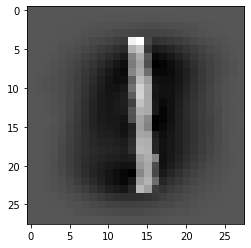

In [8]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation].astype(np.int)
X = X.reshape((X.shape[0], -1))
print(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T

# X_train = X_train.T
# X_test = X_test.T

plt.gray()
plt.imshow(X_test[:, 50].reshape(28, 28))
plt.show()

In [18]:
X_train[:, 99]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.41807799e-03, -5.75481961e-03, -4.08251693e-03, -4.08251693e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.08251693e-03, -6.22758214e-03, -9.25077752e-03, -1.21835863e-02,
       -1.53249132e-02, -1.99029541e-02, -2.51311477e-02, -3.01796547e-02,
       -3.30781150e-02, -3.29569552e-02, -3.30971892e-02, -3.06662937e-02,
       -3.04491119e-02, -2.75168402e-02, -2.25822735e-02, -1.78517586e-02,
       -1.54166835e-02, -1.09624331e-02, -8.32486080e-03, -4.38069356e-03,
        0.00000000e+00,  

In [ ]:
mnist_net = NeuralNet('multi_logloss')
mnist_net.addLayer(64, 'reLu')
mnist_net.addLayer(10, 'softmax')
costs = mnist_net.fit(X_train, y_train, 100, 60000)
plt.plot(costs)

> <ipython-input-23-de3595b3c639>(100)fit()
     99                 ipdb.set_trace()
--> 100                 for layer in self.layers:
    101                     A = layer.feedForward(A)

ipdb> nn
*** NameError: name 'nn' is not defined
ipdb> 
*** NameError: name 'nn' is not defined
ipdb> n
> <ipython-input-23-de3595b3c639>(101)fit()
    100                 for layer in self.layers:
--> 101                     A = layer.feedForward(A)
    102                 batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))

ipdb> n
> <ipython-input-22-d37b39fd691b>(50)feedForward()
     49         ipdb.set_trace()
---> 50         self.A_prev = A_prev
     51         self.Z = self.W.dot(self.A_prev) + self.b

ipdb> n
> <ipython-input-22-d37b39fd691b>(51)feedForward()
     50         self.A_prev = A_prev
---> 51         self.Z = self.W.dot(self.A_prev) + self.b
     52         self.A = self.act(self, self.Z)

ipdb> n
> <ipython-input-22-d37b39fd691b>(52)feedForward()
     5

<ipython-input-22-d37b39fd691b>:22: RuntimeWarning: overflow encountered in exp
  return np.exp(Z) / sum(np.exp(Z))
<ipython-input-22-d37b39fd691b>:22: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(Z) / sum(np.exp(Z))


> <ipython-input-22-d37b39fd691b>(53)feedForward()
     52         self.A = self.act(self, self.Z)
---> 53         return self.A
     54 

ipdb> n
--Return--
array([[1.409...5618645e-24]])
> <ipython-input-22-d37b39fd691b>(53)feedForward()
     52         self.A = self.act(self, self.Z)
---> 53         return self.A
     54 

ipdb> n
> <ipython-input-23-de3595b3c639>(100)fit()
     99                 ipdb.set_trace()
--> 100                 for layer in self.layers:
    101                     A = layer.feedForward(A)

ipdb> n
> <ipython-input-23-de3595b3c639>(102)fit()
    101                     A = layer.feedForward(A)
--> 102                 batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
    103                 dZ_Special = A - y_curBatch if multiClassProblem else np.array([None])

ipdb> n
> <ipython-input-23-de3595b3c639>(103)fit()
    102                 batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
--> 103         

ipdb> n
> <ipython-input-22-d37b39fd691b>(67)backprop()
     66         # because it is actually a sum of weights
---> 67         dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
     68 

ipdb> dZ == dZ_Special
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
ipdb> dZ.shape
(10, 60000)
ipdb> n
> <ipython-input-22-d37b39fd691b>(72)backprop()
     71         # and divide by total num of smamples)
---> 72         db = 1 / dZ.shape[1] * np.sum(dZ, axis = 1, keepdims = True)
     73 

ipdb> n
> <ipython-input-22-d37b39fd691b>(74)backprop()
     73 
---> 74         dA_prev = np.dot(self.W.T, dZ)
     75 

ipdb> n
> <ipython-input-22-d37b39fd691b>(76)backprop()
     75 
---> 76         self.W = self

ipdb> self.W.shape
(10, 64)


In [32]:
array([ 0.        ,  0.        ,  0.        , 12.34557301,  0.        ,
        1.44547623,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 14.42673622, 11.38719467,  0.        ,
        5.75124653, 27.30509425, 14.13349396, 16.0829925 ,  0.        ,
        0.        , 12.09050004,  0.24301809,  0.        ,  0.81315813,
       36.25892928,  3.02591285,  0.        ,  7.69811406,  0.        ,
        0.        ,  0.        , 23.42250571,  6.57030016,  2.73966946,
        0.        ,  0.        ,  0.        , 13.62185096,  7.91879562,
       22.05083927,  0.        , 29.15894322, 15.4927778 ,  0.        ,
        0.        , 16.55078204, 13.3898415 ,  0.        ,  0.        ,
        0.        , 19.41925836,  0.        ,  0.        ,  0.        ,
       15.12313668,  8.86435797, 14.11965046,  0.        ,  0.        ,
        0.        ,  0.37141094,  3.19106955, 27.12674025])

NameError: name 'array' is not defined